# Using the Cloud Mask

Here, we'll explore Hydrosat's cloud and quality assurance masks to better understand the information encoded within them.

## 1. Accessing Hydrosat's STAC API

### 1.1 Import dependencies

In [46]:
import json
import pystac
from pystac_client import Client
import base64

### 1.2 Connect to the API with your account credentials

To run the next cell, you should have set up a `creds.json` file containing your username and password in the same directory as this notebook.

In [47]:
with open('creds.json') as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://stac.hydrosat.com/'
catalog = Client.open(cat_url, headers)

Let's search the catalog for data in the ```vz-l2``` collection near Santa Barbara, CA from mid-2025.

In [64]:
search = catalog.search(
        collections = ['vz-l2'],
        datetime = ['2025-04-15', '2025-07-15'],
        bbox = [-120.6612, 34.4446, -120.4057, 34.6164]
    )

items = list(search.items())
items.reverse()
item = items[0] # Get the first item in the list

## 2. Explore the cloud mask asset

### 2.1 Access the cloud mask COG

In [66]:
import rioxarray as rxr
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np

cloud_mask = rxr.open_rasterio(item.assets['CLOUD_MASK'].href)

### 2.2 Visualize the cloud mask

Here, we'll define and use a function to plot the mask with a discrete colormap.

In [85]:
def plot_mask(data, set_min=True, title=None, cmap='cubehelix', vmin=None, vmax=None, colorbar_label=None):
    '''
    data: a DataArray containing quality or cloud mask data
    set_min: boolean, if True, sets the color for the minimum value to white
    title: None or string representing the title of the plot
    cmap: colormap to be used with plt.imshow()
    vmin, vmax: min and max values for the colormap
    colorbar_label: None or string
    '''
    data = data.squeeze() # Remove extra dimension if present

    min_val = int(data.min().values)
    max_val = int(data.max().values)
    n_colors = max_val - min_val +1

    cmap = sns.color_palette(cmap, n_colors) # Discrete cmap with breaks at every integer
    if set_min: cmap[0] = 'whitesmoke' # set specific color for min
    cmap = mcolors.ListedColormap(cmap)

    bounds = np.arange(min_val, max_val+2)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12,10))
    plot = plt.imshow(data, cmap=cmap, norm=norm)
    if colorbar_label is not None:
        tick_locs = np.arange(min_val+0.5, max_val+1.5, 1)
        cbar = plt.colorbar(plot, label=colorbar_label, ticks=tick_locs)
        cbar.ax.set_yticklabels(np.arange(min_val, max_val+1))
    plt.xticks([])
    plt.yticks([])
    plt.title(title, weight='bold')
    plt.tight_layout()
    plt.show()
    return

Let's plot the cloud mask for the item of interest.

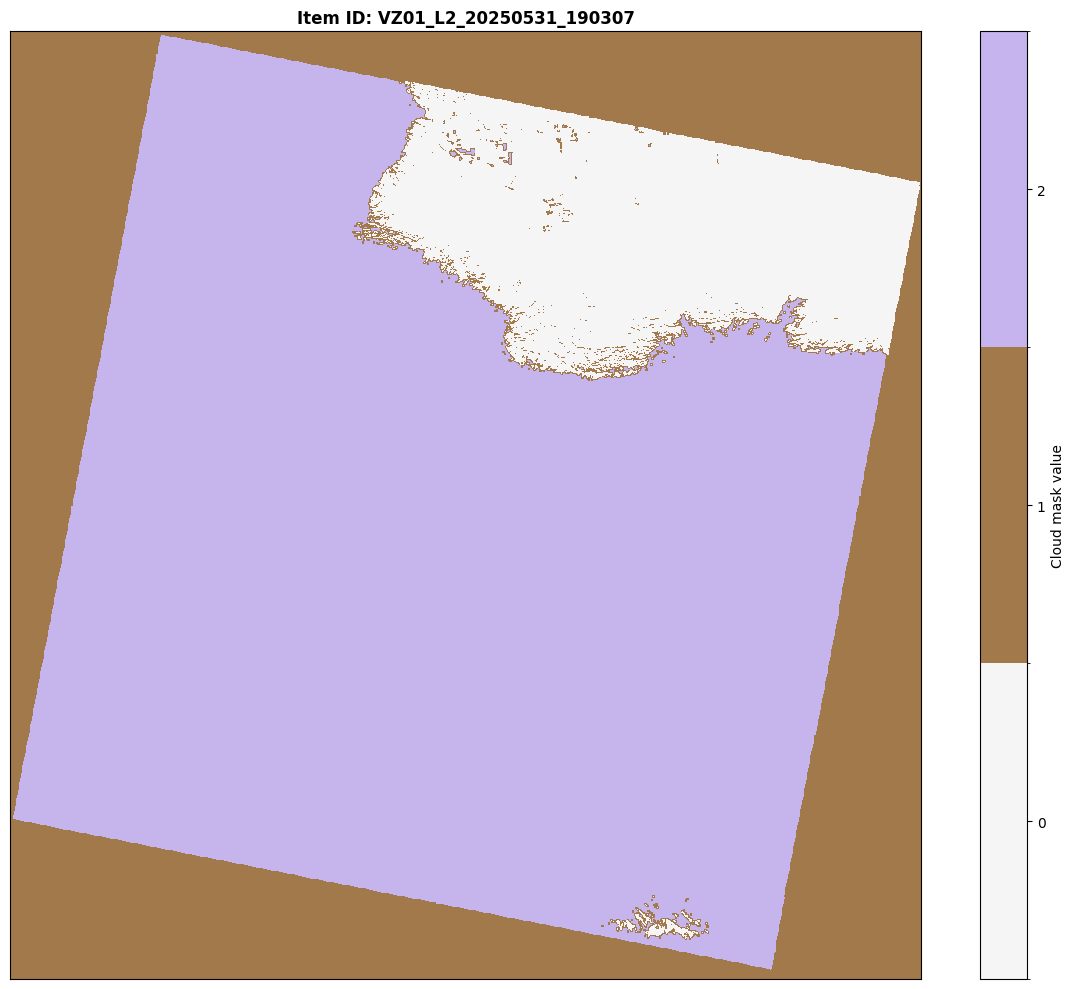

In [86]:
plot_mask(cloud_mask, title=f'Item ID: {item.id}', colorbar_label='Cloud mask value')

The cloud mask includes bit-packed values, so we'll need to unpack them to understand what they represent. 

We'll explore this in the next section.

### 2.3 Interpret the cloud mask pixel values

First, we'll need to write a function to convert a given binary value to a 16-bit binary string.

In [52]:
def decimal_to_binary(value, bit_length=16):
    return format(value, f'0{bit_length}b')

Next, we'll create a dict with information about each bit's meaning. This information is available on the FAQs page and in our product guide.

In [53]:
# Interpretation of bits 0-4 when set to True
cloud_mask_bit_meanings = {
    0: "No data",
    1: "Cloud",
    2: "Cloud shadow",
    3: "Snow or ice"
}

Finally, we'll display a lookup table for each unique pixel value from the cloud mask.

This function takes the cloud mask and bit definitions as input and outputs a table of pixel values mapped to their meanings.

In [70]:
import pandas as pd

def make_lookup_table(mask, meanings):

    unique_decimal_values = np.unique(mask)
    binary_strings = [decimal_to_binary(int(val)) for val in unique_decimal_values]

    df = pd.DataFrame({
        "Decimal": unique_decimal_values,
        "Binary": binary_strings
    })

    # Add Yes/No columns for each bit
    for bit, bit_name in meanings.items():
        df[bit_name] = ["Yes" if binary[-(bit + 1)] == "1" else "No" for binary in binary_strings] # -(bit + 1) ensures we are reading the string from right to left

    return df

In [71]:
cloud_LUT = make_lookup_table(cloud_mask, cloud_mask_bit_meanings)
cloud_LUT

,Decimal,Binary,No data,Cloud,Cloud shadow,Snow or ice
0,0.0,0000000000000000,No,No,No,No
1,1.0,0000000000000001,Yes,No,No,No
2,2.0,0000000000000010,No,Yes,No,No


There we go! Each pixel value represents a specific set of conditions. For example, a value of 2 indicates cloudy conditions; a value of 1 represents no data; and a value of 0 represents clear conditions.

## Access the QA mask asset

The QA mask provides information about radiometric saturation in the VNIR and LWIR bands. Similar to the cloud mask, it contains bit-packed values.

First, we'll use ```rioxarray``` to access the QA mask data.

In [56]:
qa_mask = rxr.open_rasterio(item.assets['quality_assurance'].href).squeeze()

The following dict contains information about each bit's meaning.

In [57]:
# Interpretation of bits 0-8 when set to True
qa_mask_bit_meanings = {
    0: "Blue band saturation",
    1: "Green band saturation",
    2: "Red band saturation",
    3: "Red edge 1 band saturation",
    4: "Red edge 2 band saturation",
    5: "Red edge 3 band saturation",
    6: "NIR band saturation",
    7: "LWIR 1 band saturation",
    8: "LWIR 2 band saturation"
}

Let's plot the QA mask to understand the variability in pixel values.

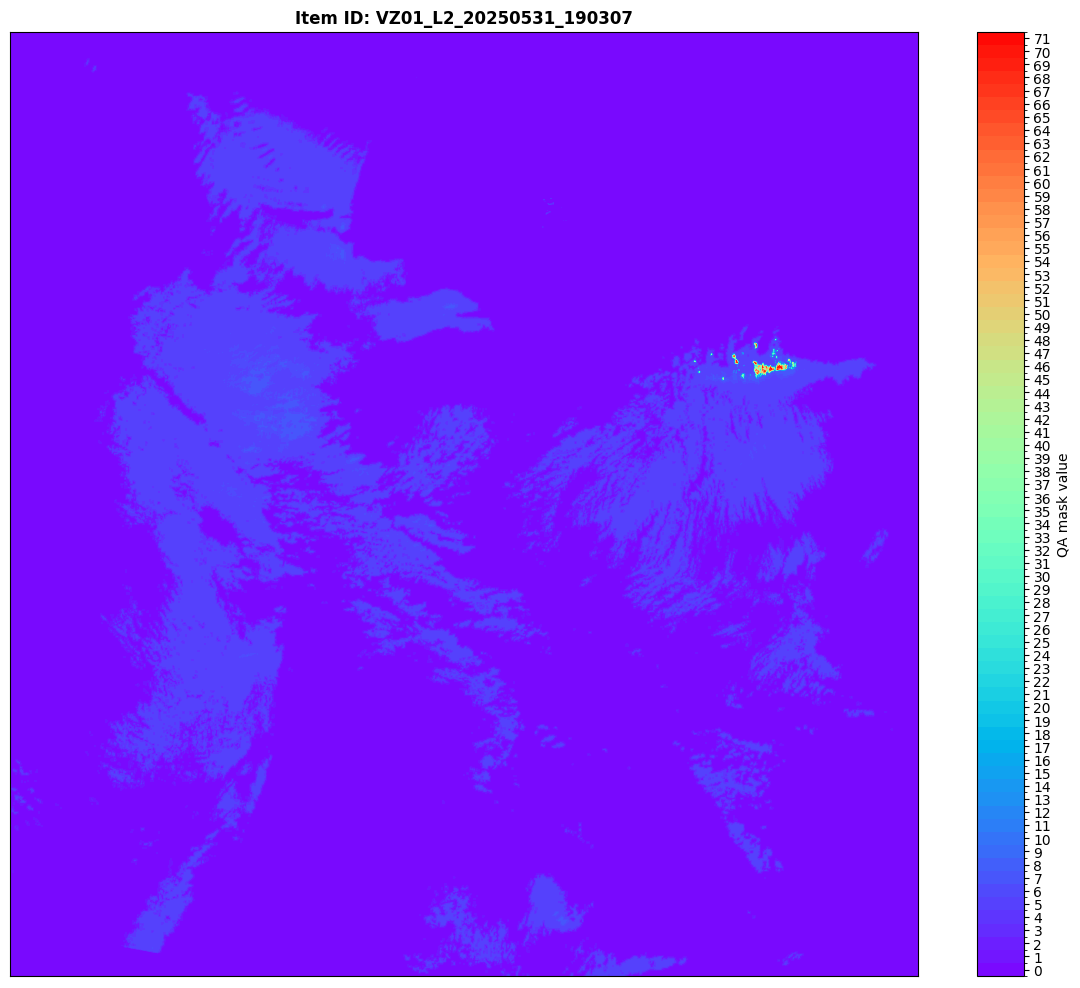

In [58]:
plot_mask(qa_mask, set_min=False, cmap='rainbow', title=f'Item ID: {item.id}', colorbar_label='QA mask value')

## Interpret the QA mask pixel values

Now, we'll use the same functions we wrote previously to interpret the pixel values from the QA mask.

In [72]:
qa_LUT = make_lookup_table(qa_mask, qa_mask_bit_meanings)
qa_LUT

,Decimal,Binary,Blue band saturation,Green band saturation,Red band saturation,Red edge 1 band saturation,Red edge 2 band saturation,Red edge 3 band saturation,NIR band saturation,LWIR 1 band saturation,LWIR 2 band saturation
0,0,0000000000000000,No,No,No,No,No,No,No,No,No
1,1,0000000000000001,Yes,No,No,No,No,No,No,No,No
2,2,0000000000000010,No,Yes,No,No,No,No,No,No,No
3,3,0000000000000011,Yes,Yes,No,No,No,No,No,No,No
4,4,0000000000000100,No,No,Yes,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...
67,67,0000000001000011,Yes,Yes,No,No,No,No,Yes,No,No
68,68,0000000001000100,No,No,Yes,No,No,No,Yes,No,No
69,69,0000000001000101,Yes,No,Yes,No,No,No,Yes,No,No
70,70,0000000001000110,No,Yes,Yes,No,No,No,Yes,No,No


The bottom line is that a pixel value of 0 means that no bands are saturated, while a nonzero pixel value indicates some saturation.